## Etape 2 : Statistiques descriptives

### Import des librairies et analyse du jeu de données

Import des différentes librairies utiles à l'analyse :

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from datetime import datetime
import time
import seaborn as sns

Il est nécessaire d'installer et d'importer "importnb" pour avoir accès aux fonctionns définies dans "algoStatCourse" :

In [2]:
#pip install importnb

In [3]:
from importnb import Notebook
with Notebook():
    import algoStatCourse

12


Il faut ensuite importer un jeu de donnée. On prend le jeu de données correspondant aux 10 kilomètres de Riorges comme exemple pour l'analyse:

In [4]:
data=pd.read_csv("10_km_Riorges.csv")

Comme chaque jeu de données extrait, nous avons à notre disponibilité le nom et prénom de chaque athlète, leur performance, leur années de naissance, la catégorie à laquelle ils appartiennent, leur temps, ainsi que leur écart de temps avec le premier.

In [5]:
data.head()

,Athlète,Ligue,Performance,Naissance,Catégorie,time_delta,time_gap,duration,Nom,Prénom
0,LORTON Guillaume,ARA,N4,1989,SEM,0 days 00:30:58,0 days 00:00:00,1858.0,LORTON,Guillaume
1,BETRON Adrien,ARA,IR1,1989,SEM,0 days 00:31:30,0 days 00:00:32,1890.0,BETRON,Adrien
2,MOULIN Loic,ARA,IR2,1992,SEM,0 days 00:32:01,0 days 00:01:03,1921.0,MOULIN,Loic
3,DEBROUCKER Guillaume,ARA,IR2,1982,M1M,0 days 00:32:15,0 days 00:01:17,1935.0,DEBROUCKER,Guillaume
4,KEMEI Charles,ARA,IR2,1984,M0M,0 days 00:32:40,0 days 00:01:42,1960.0,KEMEI,Charles


On ajoute la variable 'h_duration' qui permet d'obtenir le temps d'arrivée dans le format heures, minutes, secondes, afin d'avoir une variable explicite pour la visualisation.

In [6]:
data['h_duration'] = data['duration'].apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S'))

Nous analysons maintenant les statistiques descriptives du temps d'arrivée afin de connaitre rapidement la forme des données, et la présence de possible valeurs abérantes, pour guider la construction des visualisations utile à l'athlète. Dans ce jeu de données, nous n'avons à première vue pas de potentiels valeurs abbérantes étant données que les temps sont environ réparti entre 30 et 70 mn, temps normaux pour une course de 10 km.

In [7]:
(data['duration']/60).describe()

count    250.000000
mean      46.830600
std        8.432333
min       30.966667
25%       39.666667
50%       46.158333
75%       52.758333
max       70.750000
Name: duration, dtype: float64

### Construction des visualisations et données utiles à l'athlète

On utilise maintenant algoStatCourse pour construire un graphique rendant compte de la position de l'athlète dans la densité des temps d'arrivée.

In [8]:
densite=algoStatCourse.dens(data['duration'], bins = 12) #Calcul de la densité de la variable 'duration'
fcubic=algoStatCourse.lissage(densite, sep = True) #Retourne la fonction d'interpolation cubique
flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear') #Retourne la fonction d'interpolation linéaire

On définit une fonction qui permet d'appliquer une indicatrice afin de retourner la partie de la fonction qui nous intéresse. Cela sera utile pour mettre en avant les athlètes plus rapides qu'un athlète donné dans la distribution des temps.

In [9]:
def truncf (f,xmin, xmax):
    def f2 (x):
        if (x>=xmin)*(x<=xmax):
            return f(x)
        return np.nan
    
    return np.vectorize(f2)

Il est maintenant possible de définir une fonction pour visualiser la position individuelle de l'athlète dans la densité de temps de la compétition.

In [10]:
def graphePerso(prenom, nom):
    
    densite=algoStatCourse.dens(data['duration'], bins = 10) #Calcul de la densité de la variable 'duration'
    fcubic=algoStatCourse.lissage(densite, sep = True,beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation cubique
    flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear', beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation linéaire
    
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())] #numéro de l'index du participant
    
    temps = data.loc[z[0],'duration'] #temps du participant
    
    x= np.linspace(densite[0,0], densite[0,-1], int(1e5)) #x permet d'obtenir un tracé continu

    tempsAxe = np.linspace(densite[0,0],densite[0,-1],6) #définition de l'axe des abscisses en secondes avec 6 points
    labelTempsAxe = pd.Series(tempsAxe).apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S')) #Définition de la forme que prendra le temps sur l'axe des abcisses (format heures/minutes/secondes pour plus de lisibilité)

    plt.figure(figsize=(8,4.5), dpi=80) #format de la figure, (dpi pour la résolution)
    plt.fill_between(x, fcubic(x), alpha = 0.3) #fonction pour colorier l'aire sous la courbe
    plt.plot(x, fcubic(x), color = 'blue', label = 'densité lissée & interpolée')

    #plt.plot(x,flin(x), linestyle ='--', color = 'black', label = "densité réelle") #possibilité de dessiner l'interpolation linéaire au lieu de l'interpolation cubique

    plt.axvline(temps, color='r',alpha=0.3) #ligne verticale pour indiquer la position du participant sur les abscisses

    f2=truncf(fcubic, densite[0,0], temps) #on tronque fcubic pour ne retenir que la partie de la fonction des temps meilleurs à celui de l'individu
    plt.fill_between(x,f2(x), alpha = 0.6, color = 'red') #on affiche l'aire des temps meilleurs à celui de l'individu en rouge

    #plt.axvspan(temps, densite[0,0], color='r', alpha=0.3)
    plt.legend() #permet d'afficher les legendes qu'on a mises dans les arguments 'label' des fonctions juste au dessus

    # Ajout des labels et titre
    plt.title("Densité des temps d'arrivée", color= 'tab:red', fontsize = '20', fontstyle = 'oblique') # titre
    plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5) #label abscisse
    plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20) #label ordonnée
    plt.xticks(tempsAxe,labels = labelTempsAxe) #permet de choisir ce qu'on met sur l'axe des x : les coordonnees dans le premier argument, ce qu'il faut afficher dans le second.
    plt.ylim((-0.1*max(densite[1]),1.1*max(densite[1]))) #permet de choisir l'espace au dessus et au dessous du graphe
    plt.text(data.loc[z[0],'duration'],0.0001,data.loc[z[0],'Prénom'] ) # ajoute un texte directement sur le graphe
    plt.show()

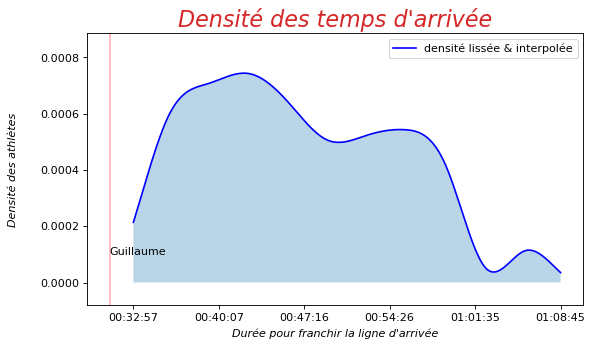

In [11]:
graphePerso("guillaume","lorton")

Test de la fonction graph perso en se restreignant à la catégorie de l'athlète : 

In [12]:
def graphePerso1(prenom, nom):
    
    z=data.index[data.Athlète==(nom.upper()+" "+prenom.capitalize())] #numéro de l'index du participant
    
    densite=algoStatCourse.dens(data['duration'][data['Catégorie']==data.loc[z[0],'Catégorie']], bins = 12) #Calcul de la densité de la variable 'duration'
    fcubic=algoStatCourse.lissage(densite, sep = True) #Retourne la fonction d'interpolation cubique
    flin=algoStatCourse.lissage(densite, sep = False, kind = 'linear', beginend = (data['duration'].min(),data['duration'].max())) #Retourne la fonction d'interpolation linéaire
    
    temps = data.loc[z[0],'duration'] #temps du participant
    
    x= np.linspace(densite[0,0], densite[0,-1], int(1e5)) #x permet d'obtenir un tracé continu

    tempsAxe = np.linspace(densite[0,0],densite[0,-1],6) #définition de l'axe des abscisses en secondes avec 6 points
    labelTempsAxe = pd.Series(tempsAxe).apply(lambda x : pd.to_datetime(x,unit="s").strftime('%H:%M:%S')) #Définition de la forme que prendra le temps sur l'axe des abcisses (format heures/minutes/secondes pour plus de lisibilité)

    plt.figure(figsize=(8,4.5), dpi=80) #format de la figure, (dpi pour la résolution)
    plt.fill_between(x, fcubic(x), alpha = 0.3) #fonction pour colorier l'aire sous la courbe
    plt.plot(x, fcubic(x), color = 'blue', label = 'densité lissée & interpolée')

    plt.plot(x,flin(x), linestyle ='--', color = 'black', label = "densité réelle") #possibilité de dessiner l'interpolation linéaire au lieu de l'interpolation cubique

    #plt.axvline(temps, color='r',alpha=0.3) #ligne verticale pour indiquer la position du participant sur les abscisses

    f2=truncf(fcubic, densite[0,0], temps) #on tronque fcubic pour ne retenir que la partie de la fonction des temps meilleurs à celui de l'individu
    plt.fill_between(x,f2(x), alpha = 0.6, color = 'red') #on affiche l'aire des temps meilleurs à celui de l'individu en rouge

    #plt.axvspan(temps, densite[0,0], color='r', alpha=0.3)
    plt.legend() #permet d'afficher les legendes qu'on a mises dans les arguments 'label' des fonctions juste au dessus

    # Ajout des labels et titre
    plt.title("Densité des temps d'arrivée", color= 'tab:red', fontsize = '20', fontstyle = 'oblique') # titre
    plt.xlabel("Durée pour franchir la ligne d'arrivée", fontstyle = 'italic', labelpad=5) #label abscisse
    plt.ylabel("Densité des athlètes", fontstyle = 'italic', labelpad=20) #label ordonnée
    plt.xticks(tempsAxe,labels = labelTempsAxe) #permet de choisir ce qu'on met sur l'axe des x : les coordonnees dans le premier argument, ce qu'il faut afficher dans le second.
    plt.ylim((-0.1*max(densite[1]),1.1*max(densite[1]))) #permet de choisir l'espace au dessus et au dessous du graphe
    plt.text(data.loc[z[0],'duration'],0,data.loc[z[0],'Prénom'] ) # ajoute un texte directement sur le graphe
    plt.show()

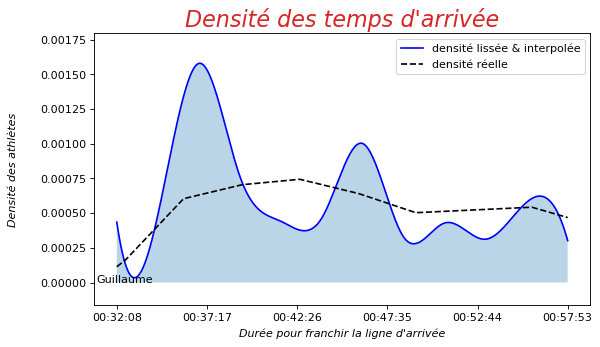

In [13]:
graphePerso1("guillaume","lorton")

In [14]:
bins = idealBins(data['duration'])

NameError: name 'idealBins' is not defined

### Construction et application de l'output des statistiques et visuels individuels

On construit d'abord deux fonctions qui permettront de demander à l'utilisateur son nom et prénom.

In [ ]:
def Prenom():
  user_input = input("Veuillez entrer votre prénom")
  return user_input

def Nom():
  user_input = input("Veuillez entrer votre nom")
  return user_input

Ici, on définit une fonction permettant de donner directement les premières informations utile, à partir du nom et prénom, de la performance individuelle relativement à la performance globale de la compétition.

In [ ]:
def info_participant():
    x=Prenom()
    y=Nom()
    if ~data['Athlète'].isin([(y.upper()+" "+x.capitalize())]).any():
        print("Le nom que vous avez entré n'est pas dans la liste des participants de la course choisie.")
    else:
        z=data.index[data.Athlète==(y.upper()+" "+x.capitalize())]
        print("Temps d'arrivé :", data.loc[z[0],'h_duration'])
        print("Position d'arrivée : ", data.index[z[0]]+1)
        print("Niveau de la performance", data.loc[z[0],'Performance'])
        print("Temps d'arrivé dans le top :", math.ceil(((data.duration<=data.loc[z[0],'duration']).sum())/len(data)*100),"%")
        print("Position parmis les", len(data[data['Catégorie']==data.loc[z[0],'Catégorie']]),"participants de la catégorie", data.loc[z[0],'Catégorie'], ":",round(data[data['Catégorie']==data.loc[z[0],'Catégorie']]['duration'].rank().loc[z[0]]))
        print("Position parmis les", len((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])), "participants ayant plus ou moins 5 ans de différence d'âge avec vous : ", round(((data[abs(data.loc[:,'Naissance']-data.loc[z[0],'Naissance'])<=5])['duration'].rank()).loc[z[0]]))
        graphePerso(x,y)

Exemple d'utilisation:

In [ ]:
info_participant()

### Information sur la compétition

Construction d'un tableau des podiums :

In [ ]:
#Extraction des différentes catégories de la compétition

Catégorie = data['Catégorie'].unique()

# Création d'un dictionaire des temps pour chaque catégorie

dict_catégorie = {}
for x in Catégorie:
    dict_catégorie[x] = data['duration'][data['Catégorie']==x]
    
#Création d'un dataframe avec les catégorie en colonnes et les temps des participants y appartenant en valeur
    
df_catégorie = pd.DataFrame(dict_catégorie)

#Tri des temps pour les 3 premiers temps de chaque catégorie


df1_catégorie=df_catégorie.copy()
for col in df1_catégorie.columns:
    for i in range(3):
        df1_catégorie[col][i] = df_catégorie[col].nsmallest(3).iloc[i]
        
#Extractio des Athlètes correspondants aux 3 premier temps de chaque catégorie
for col in df1_catégorie.columns:
    for i in range(3):
        try:
            df1_catégorie[col][i]=data[['Athlète']][data['duration']==df1_catégorie[col][i]].iloc[0,0]
        except:
            break

#Extraction des 3 premières ligne correspondant au podium
df1_catégorie=df1_catégorie.iloc[:3,:]
df1_catégorie['Podium']=['Premier','Deuxième','Troisième']
df1_catégorie = df1_catégorie.set_index('Podium')
display(df1_catégorie)

### Pistes de recherches

In [ ]:
df1=data.groupby('Naissance').agg(['count','mean','max','min','std'])
axes = plt.axes()
axes.grid() 
plt.scatter(df1.index,df1.loc[:,df1.columns[1]])
plt.show()